In [9]:
import import_ipynb                #pip install import_ipynb
from NimbRoNet2 import *
from Utils import *
from Transformation import *
from CustomDataset import *
import torch
import sys
import torch.optim as optim
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

if torch.cuda.is_available():
    avDev = torch.device("cuda")
else:
    avDev = torch.device("cpu")

batch_size = 5

print("Device : ",avDev)
print("Python Version : ",sys.version)
print("Pytorch Version : ",torch.__version__)

Device :  cuda
Python Version :  3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]
Pytorch Version :  1.3.1


In [10]:
train_transforms = [Rescale((480,640)),
              RandomVerticalFlip(),
              RandomHorizontalFlip(),
              ColorJitter(brightness=0.5, 
                          contrast=0.5, 
                          saturation=0.5,
                          hue = 0.5),
              ToTensor(), 
              Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])]

train_dataset = BlobTrainDataset(path = '../Project/data/blob/forceTrain',transform=train_transforms)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)



#print_dataloader(train_loader, num_of_image= 3, avDev = avDev)

print("Blob Train Dataset : ",len(train_dataset))

seg_train_dataset = SegDataset(path = '../Project/data/segmentation/dataset', transform= None)
seg_train_loader = torch.utils.data.DataLoader(dataset=seg_train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

print("Segmentation Train Dataset : ",len(seg_train_dataset))

# for i, test_data in enumerate(seg_train_loader):

#     plt.figure(figsize=(50,25))
#     print(test_data[0].size())
#     plt.imshow(torchvision.utils.make_grid(test_data[0], nrow=5).permute(1, 2, 0))
#     plt.show()
#     plt.figure(figsize=(50,25))
# #     plt.imshow(torchvision.utils.make_grid(test_data[1], nrow=1).permute(1, 2, 0))
#     print(test_data[1].size)
#     plt.imshow(torchvision.utils.make_grid(test_data[1][0], nrow=5).permute(1, 2, 0))
#     plt.show()
# #     print(np.array(test_data[1][0]))
#     raise KeyboardInterrupt

Blob Train Dataset :  3598
Segmentation Train Dataset :  1108


In [11]:
model = NimbRoNet2()
model.to(avDev)

criterion_blob = nn.MSELoss()
criterion_seg = nn.CrossEntropyLoss()

criterion_blob.to(avDev)
criterion_seg.to(avDev)

optimizer = optim.Adam([
                        {"params":model.e_block1.parameters(), "lr": 0.000001},
                        {"params":model.e_block2.parameters(), "lr": 0.000001},
                        {"params":model.e_block3.parameters(), "lr": 0.000001},
                        {"params":model.e_block4.parameters(), "lr": 0.000001},
                        {"params":model.d_block1.parameters()},
                        {"params":model.d_block2.parameters()},
                        {"params":model.d_block3.parameters()},
                        {"params":model.d_block4.parameters()},
                        {"params":model.conv_1_1.parameters()},
                        {"params":model.conv_1_2.parameters()},
                        {"params":model.conv_1_3.parameters()}], lr=0.001)

checkpoint = torch.load("../model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
no_epoch = checkpoint['epoch']
print("No of epoch : ",no_epoch)
train_loss_1 = checkpoint['train_loss1']

No of epoch :  5


In [12]:
total_loss = 0.0
loss_details = [None]*100
train_loss = 0.0

combined_loader = [train_loader, seg_train_loader]

for epoch in range(no_epoch , no_epoch + 5):

    print("epoch",epoch)
    train_loss, model = train_model(model, "blob", combined_loader, criterion_blob, criterion_seg, optimizer, avDev)
    loss_details[epoch] = train_loss
    print("train loss",train_loss)
    total_loss += train_loss
    #print("total loss", total_loss)

  0%|          | 0/720 [00:00<?, ?it/s]

epoch 5


  0%|          | 0/720 [00:00<?, ?it/s]

train loss 3.226332426071167
epoch 6


  0%|          | 0/720 [00:00<?, ?it/s]

train loss 3.1432290077209473
epoch 7


  0%|          | 0/720 [00:00<?, ?it/s]

train loss 3.0584492683410645
epoch 8


  0%|          | 0/720 [00:00<?, ?it/s]

train loss 2.988328695297241
epoch 9


100%|██████████| 720/720 [08:00<00:00,  1.50it/s]

train loss 2.917776346206665


In [13]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss1': loss_details,
            }, "../model.pth")


Recall of Ball 1.0
Recall of Goalpost 0.5
Recall of Robot 0.67
FDR of Ball 0.0
FDR of Goalpost 0.38
FDR of Robot 0.12
Total recall 0.72
Total FDR 0.17
Accuracy 0.65


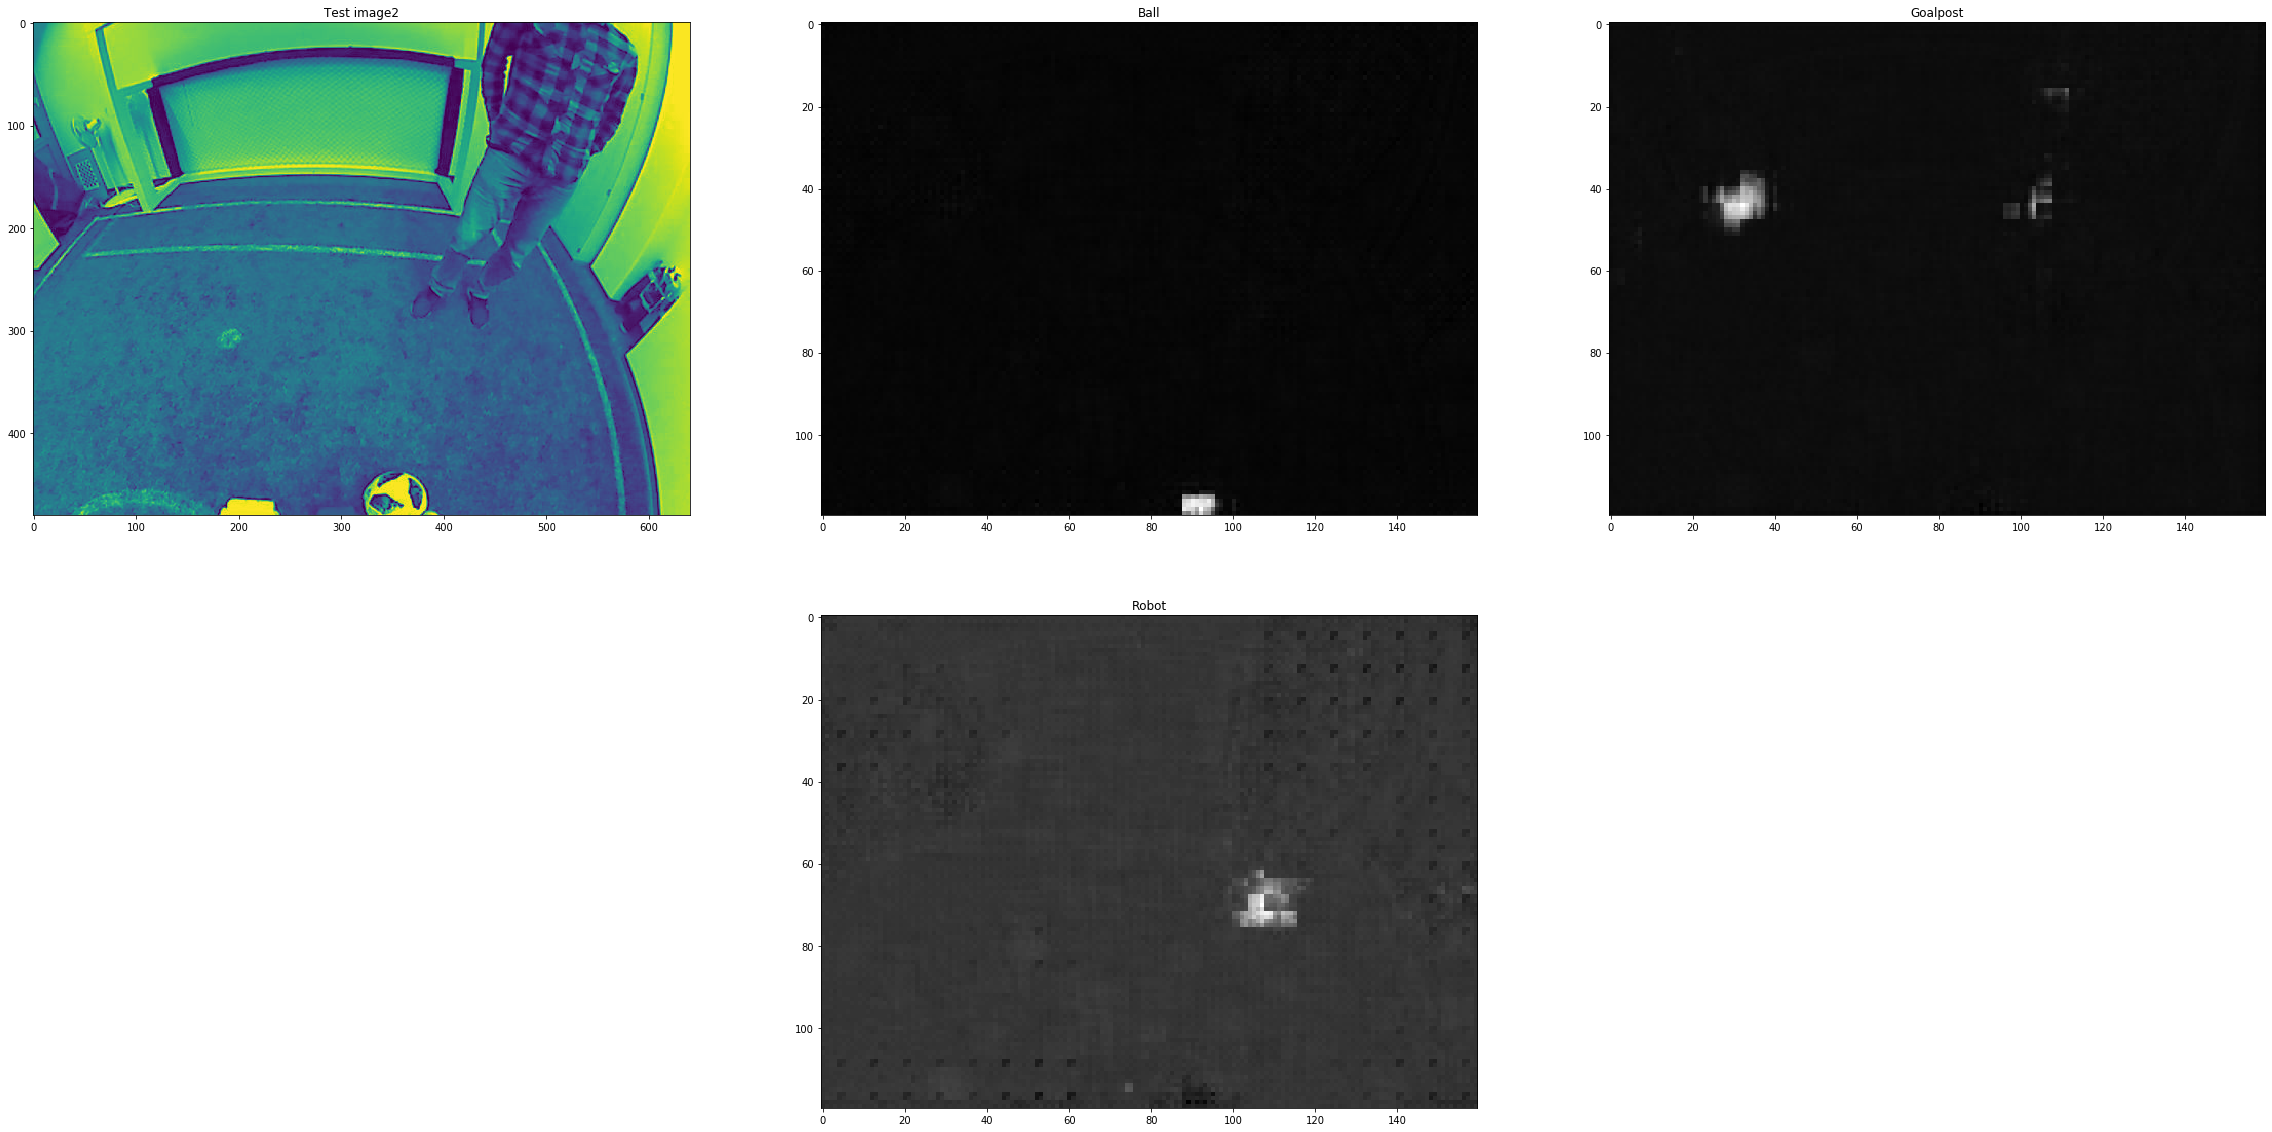

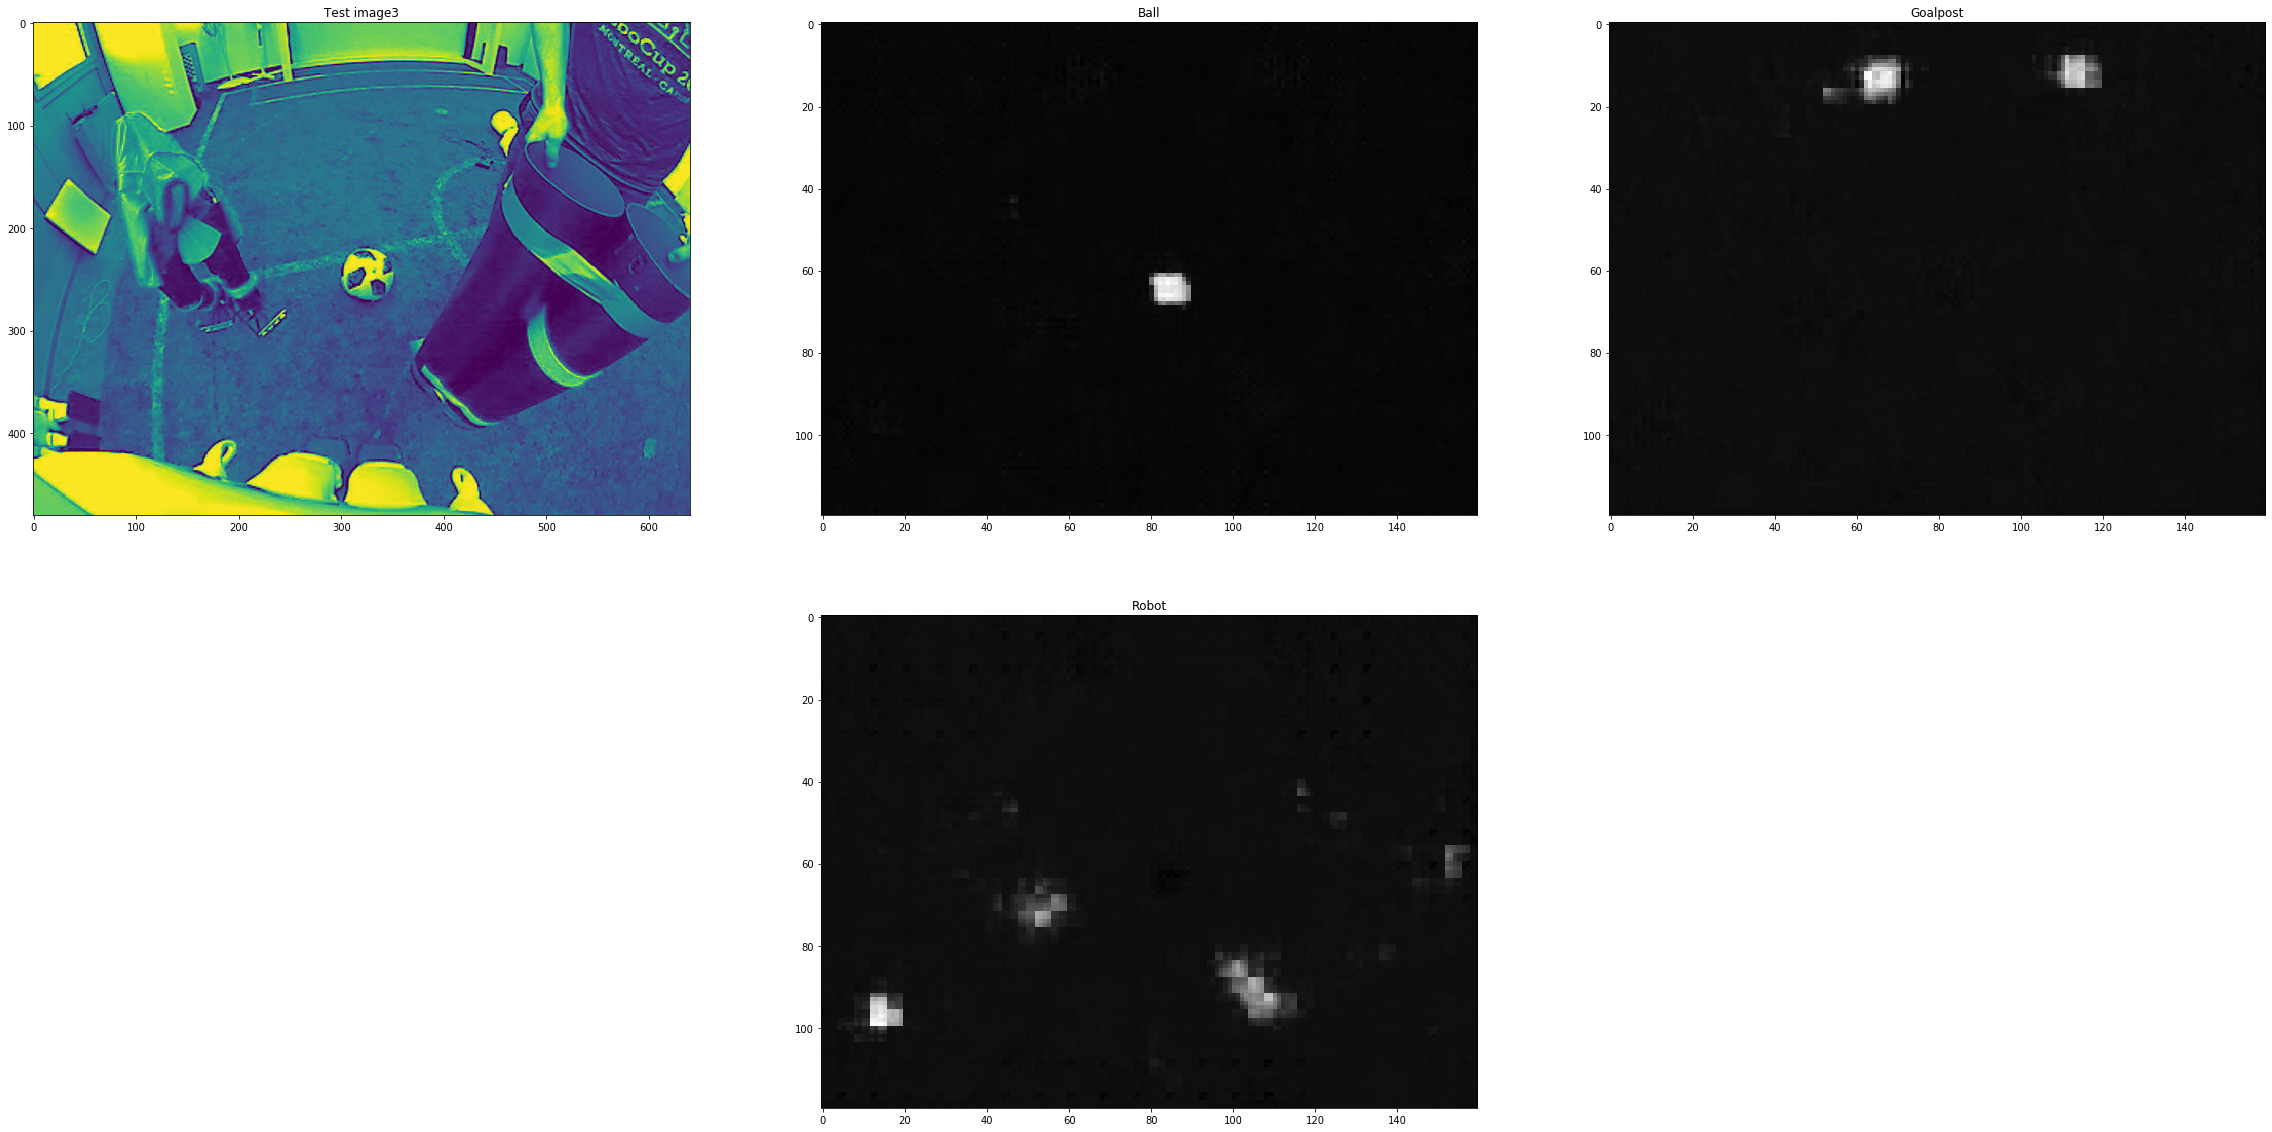

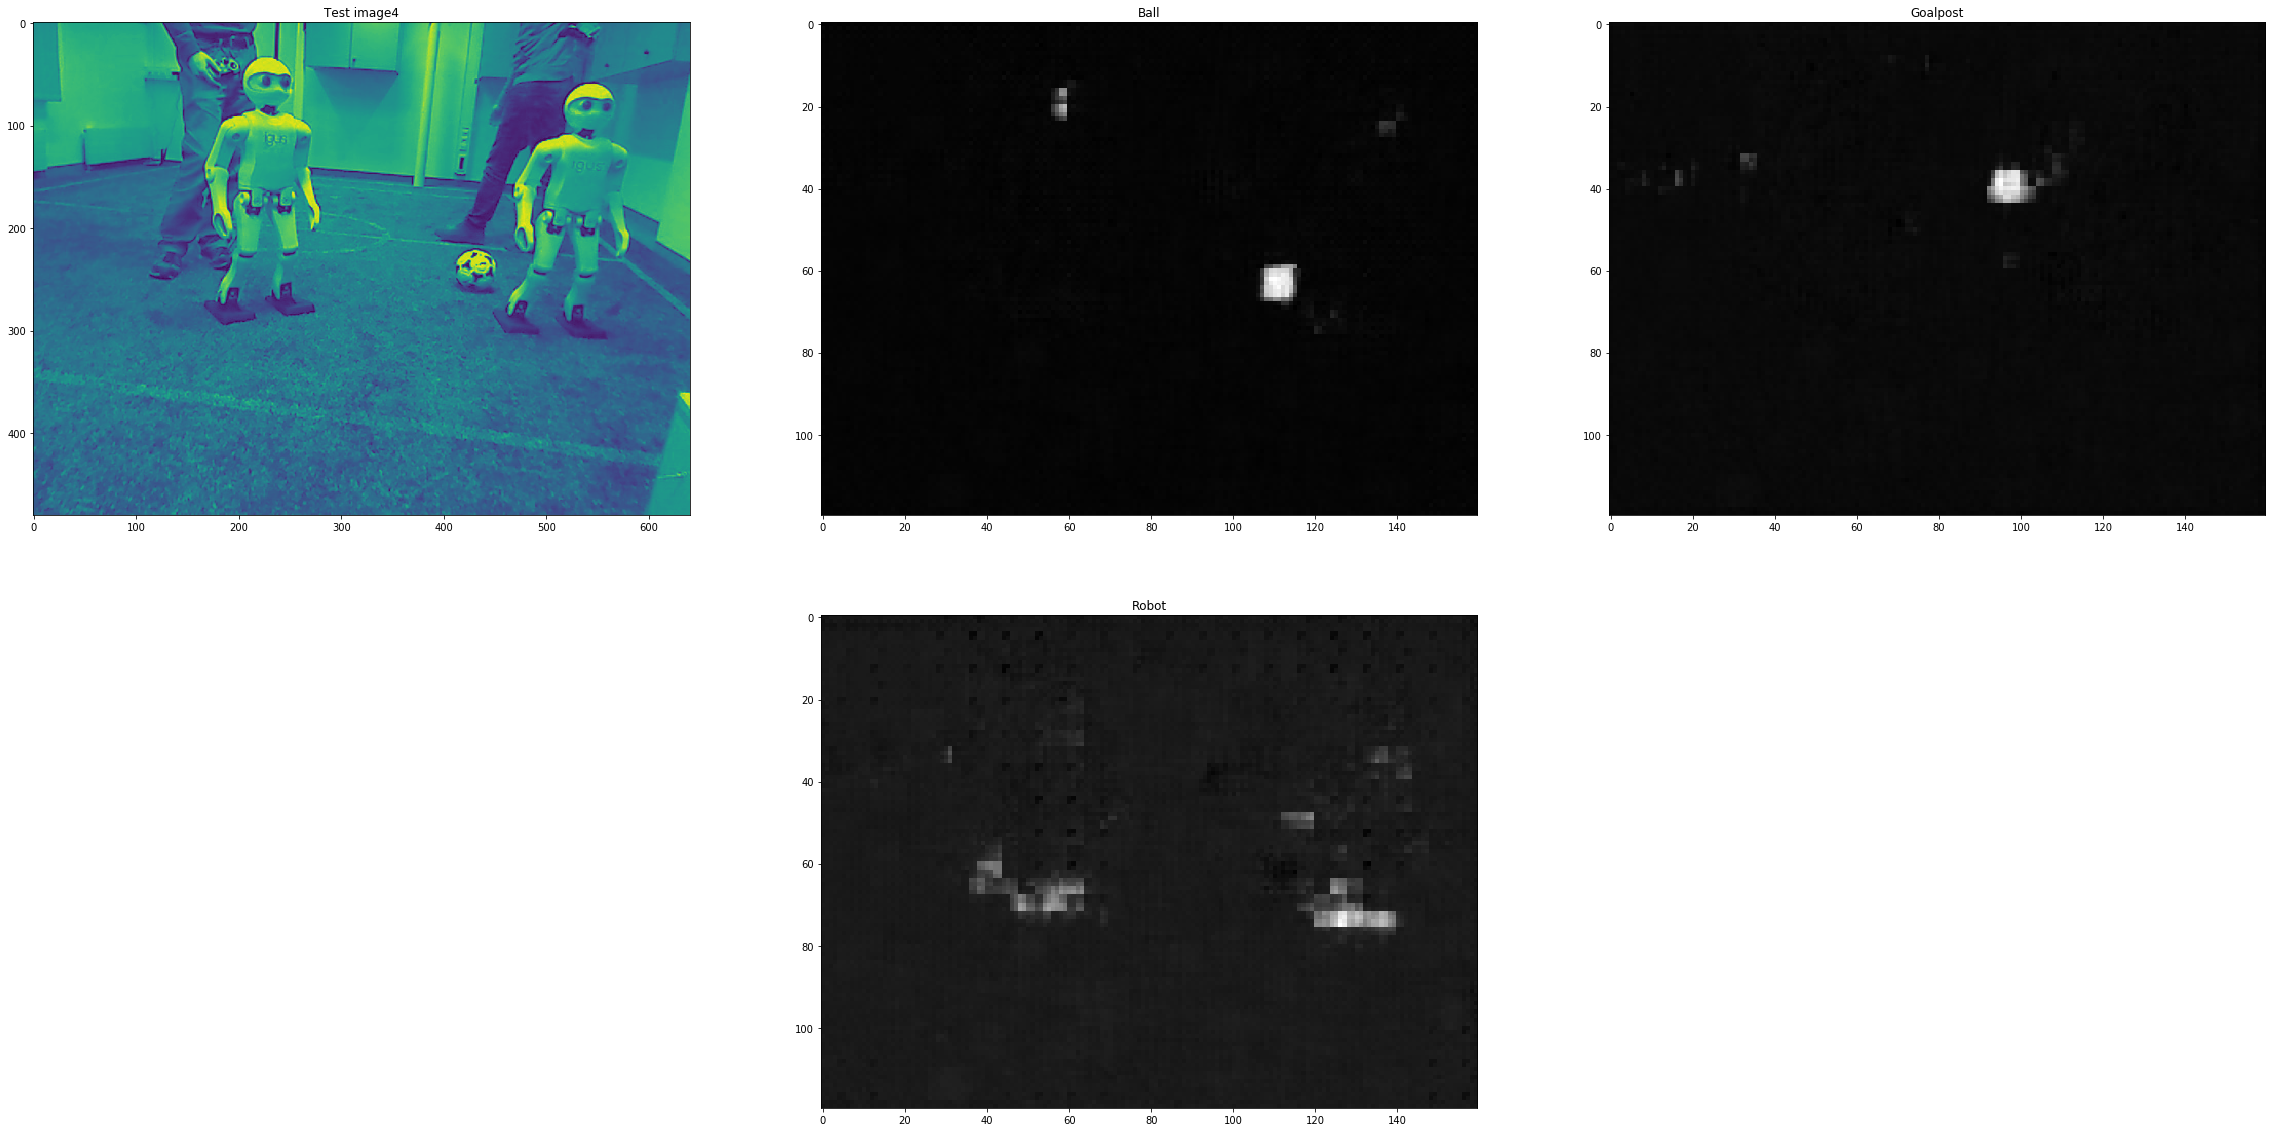

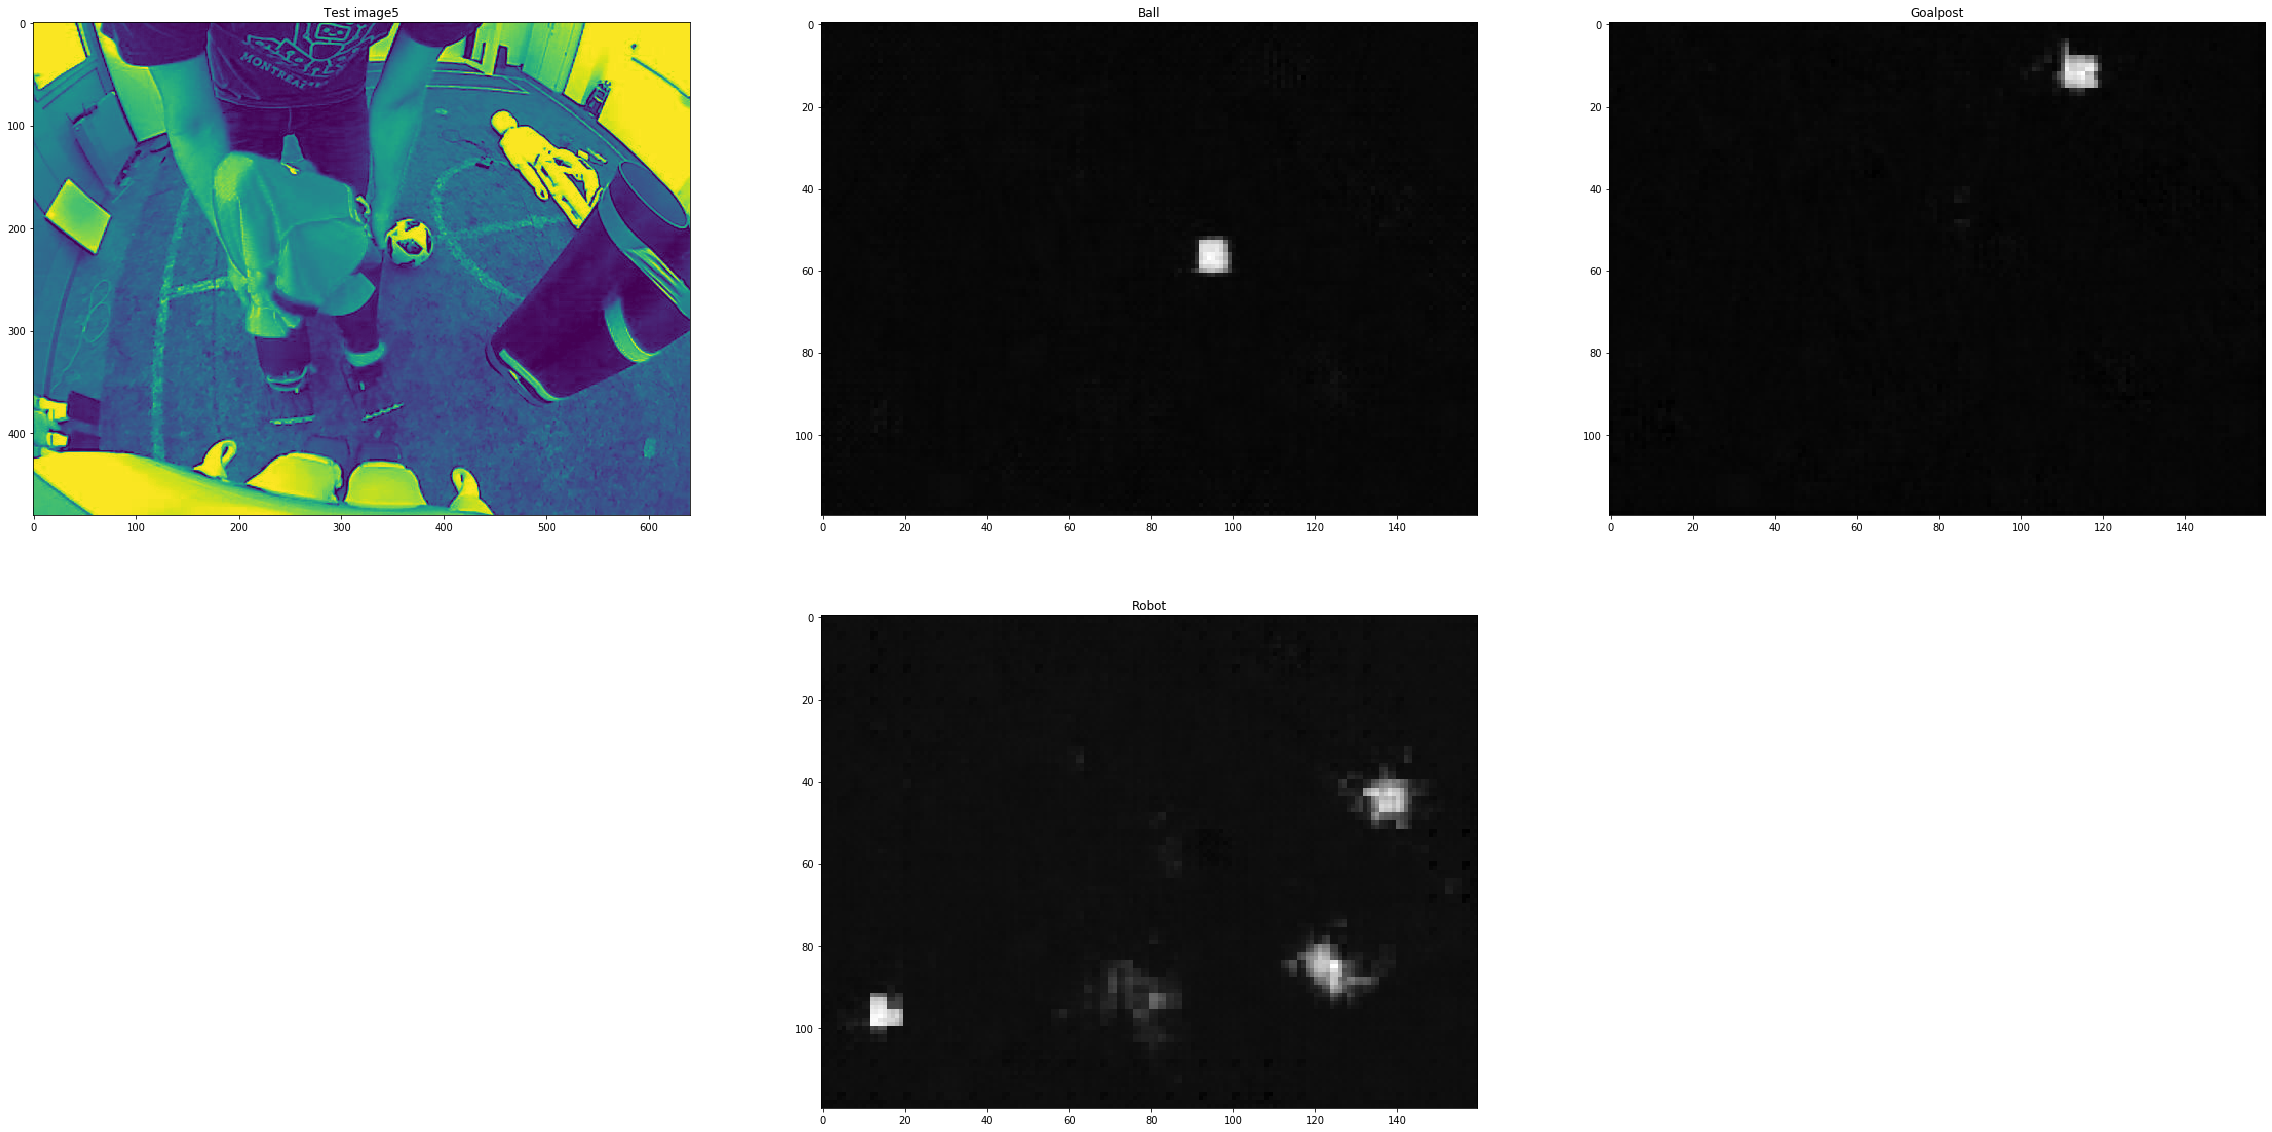

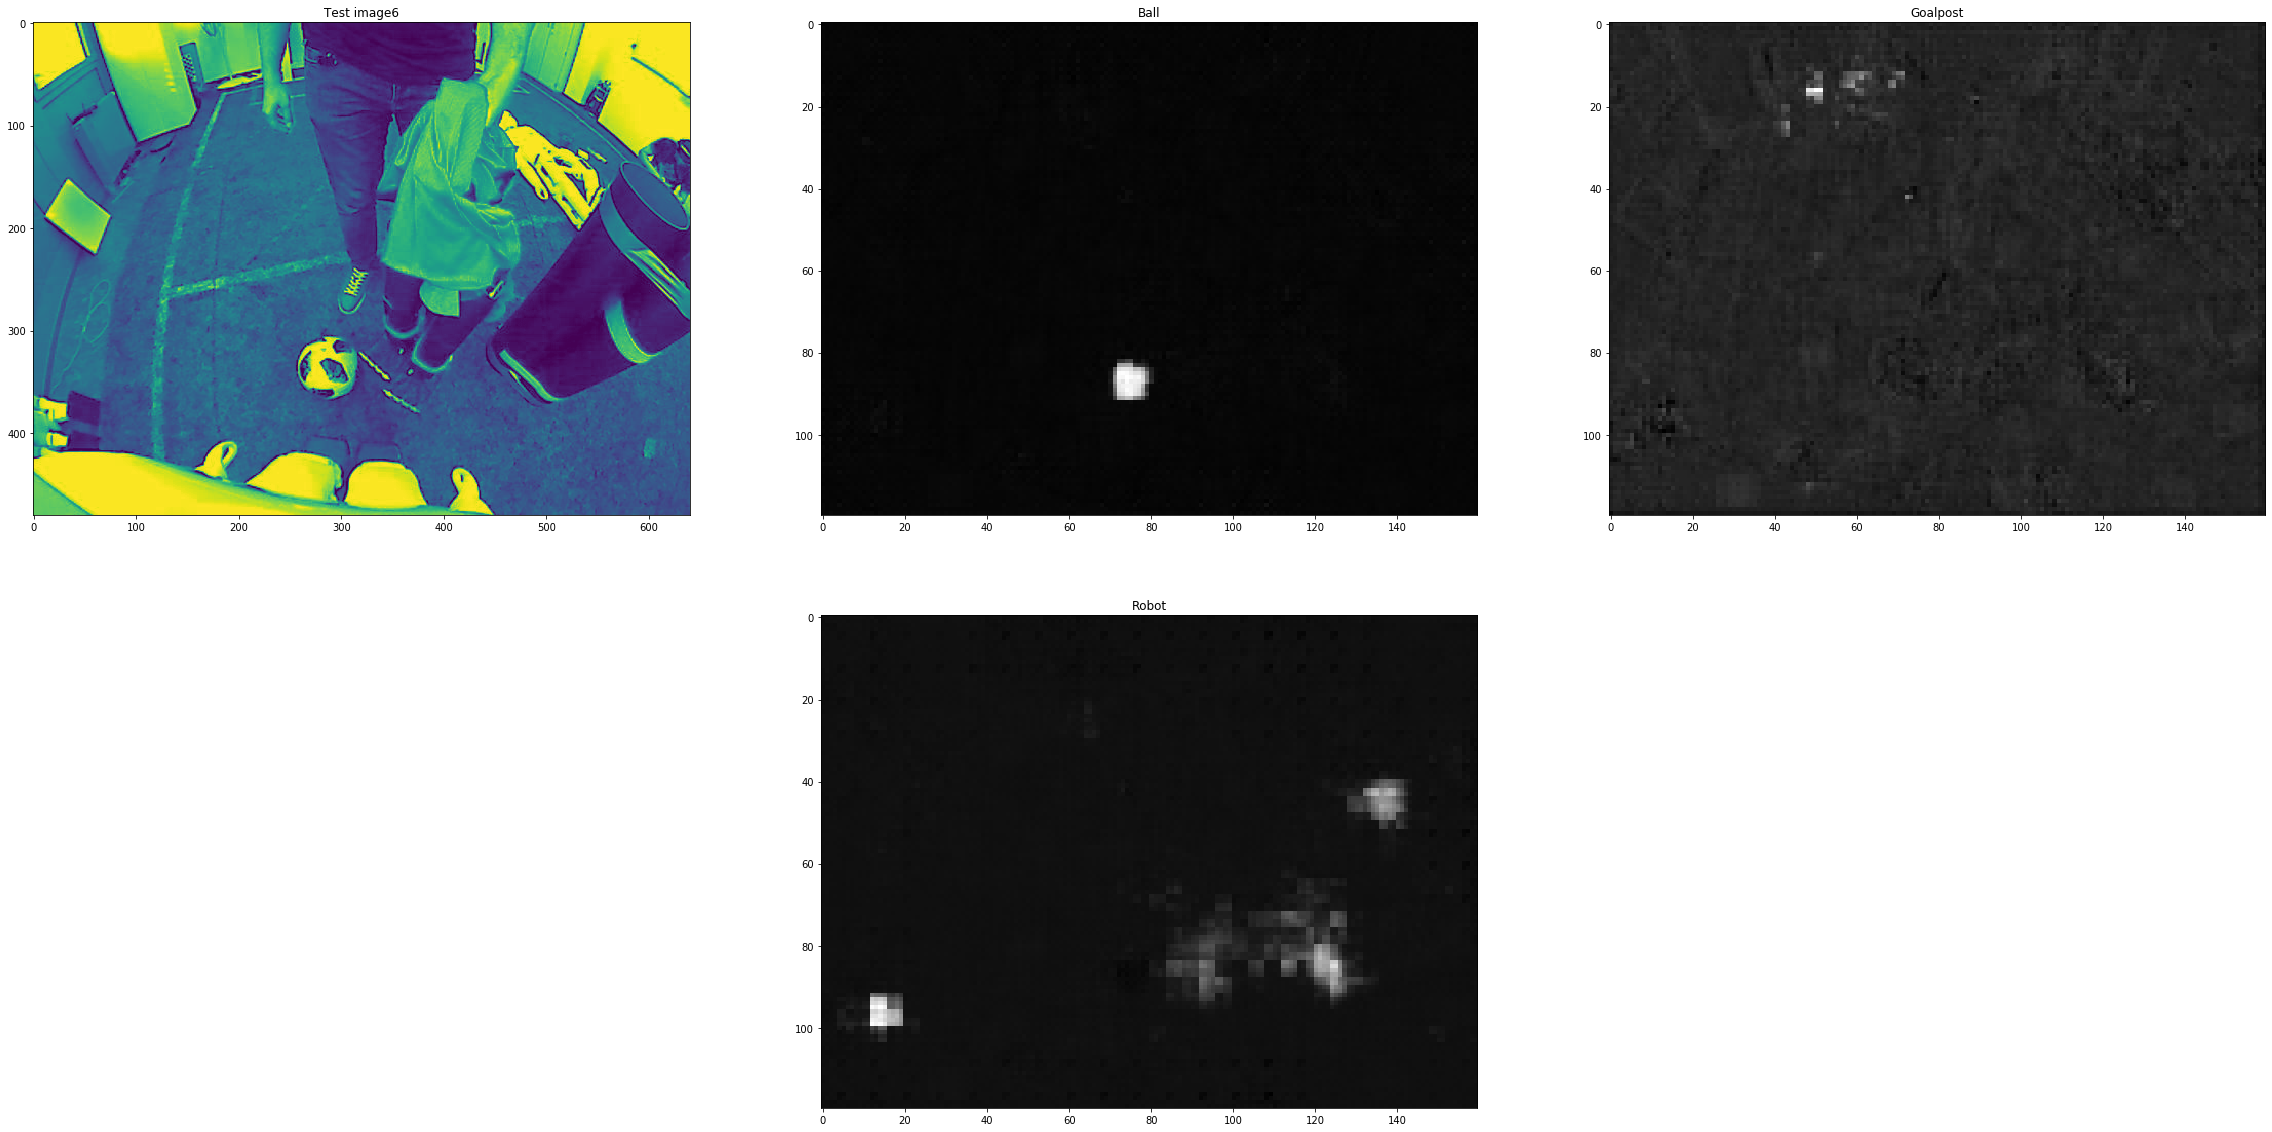

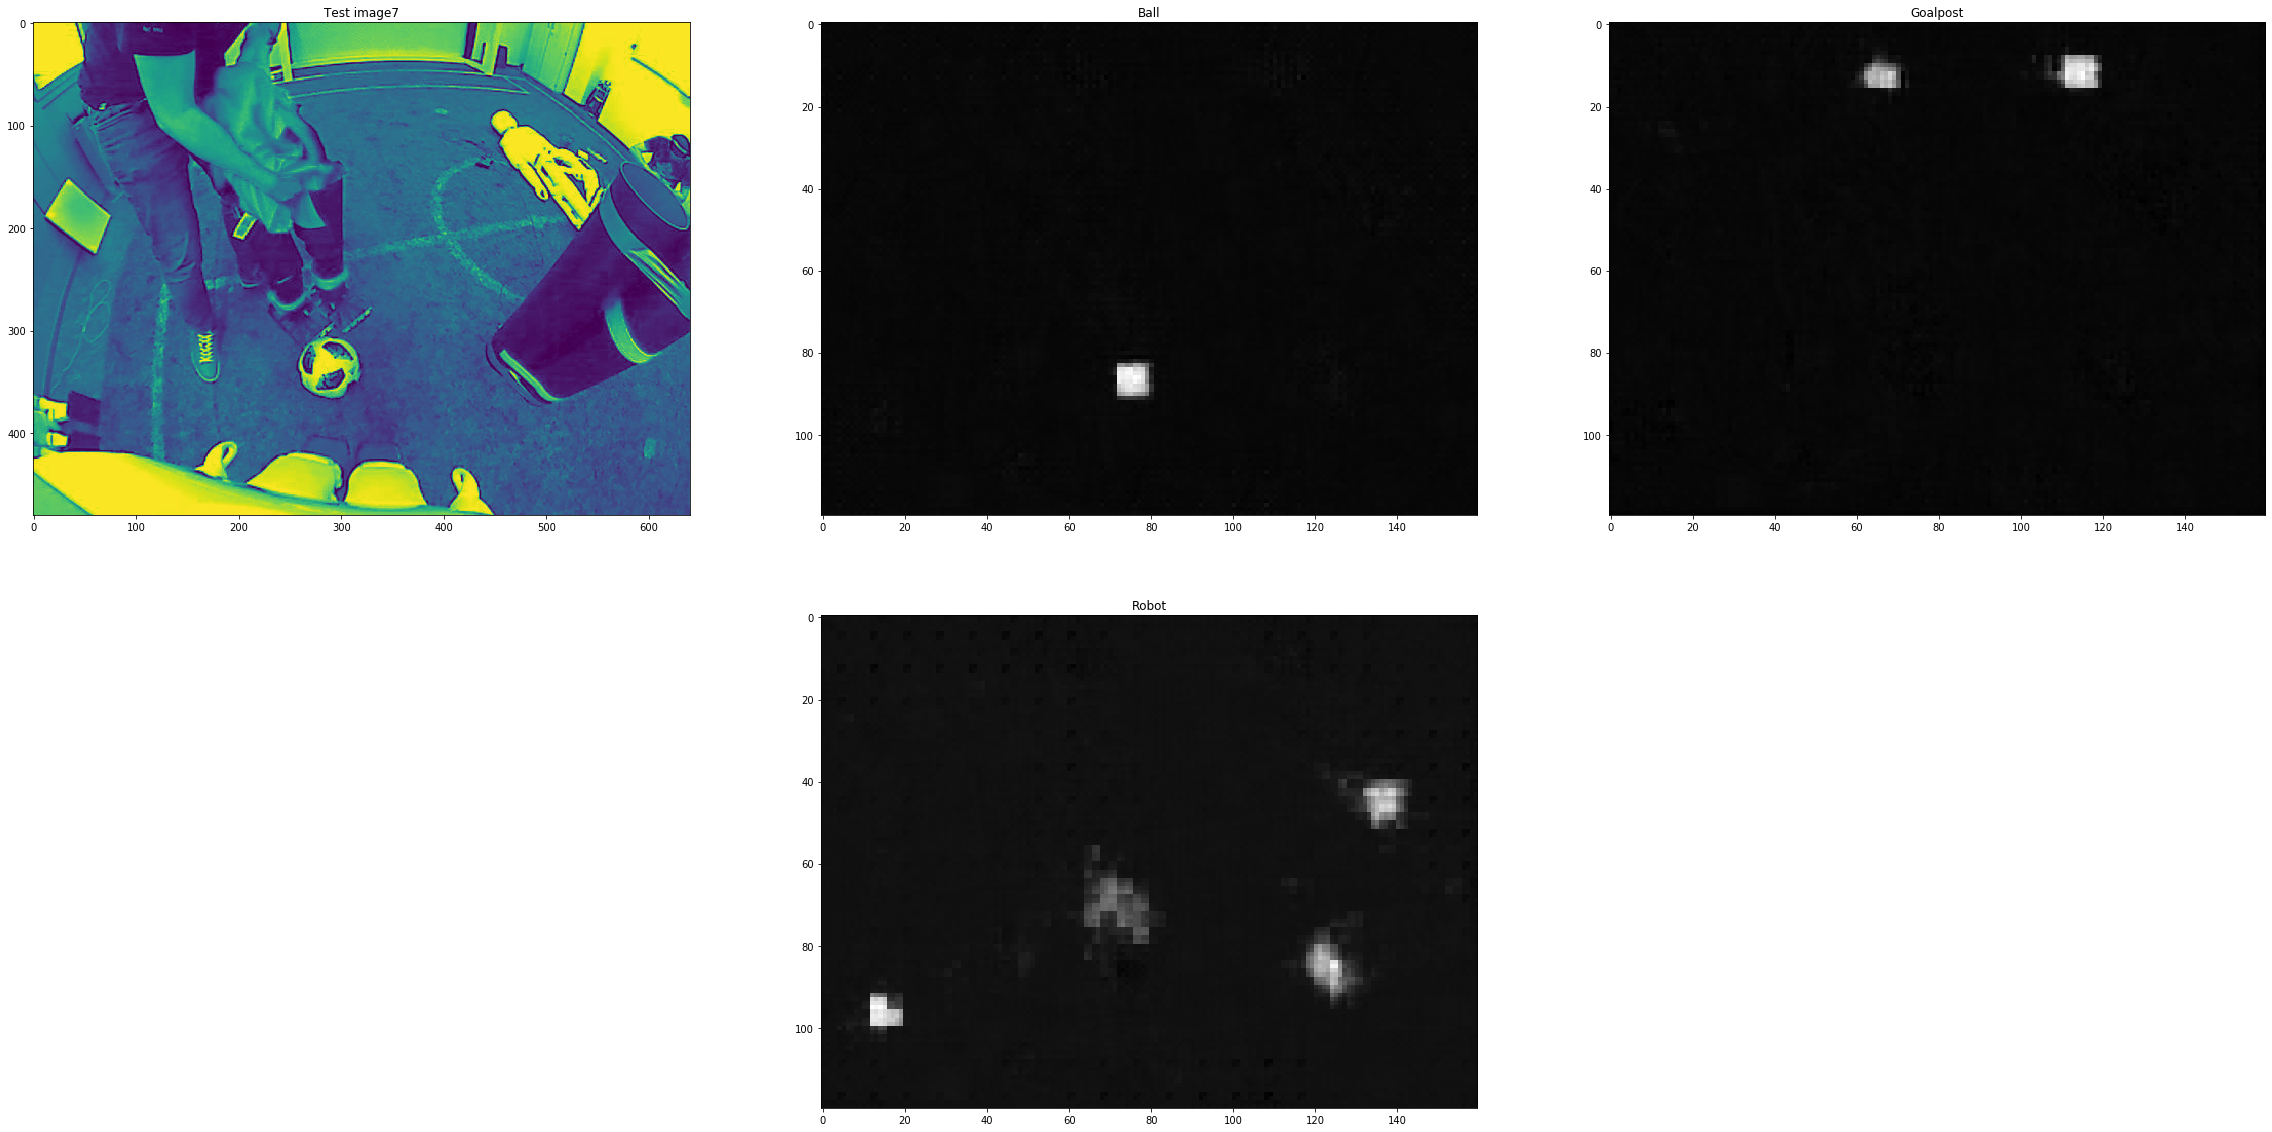

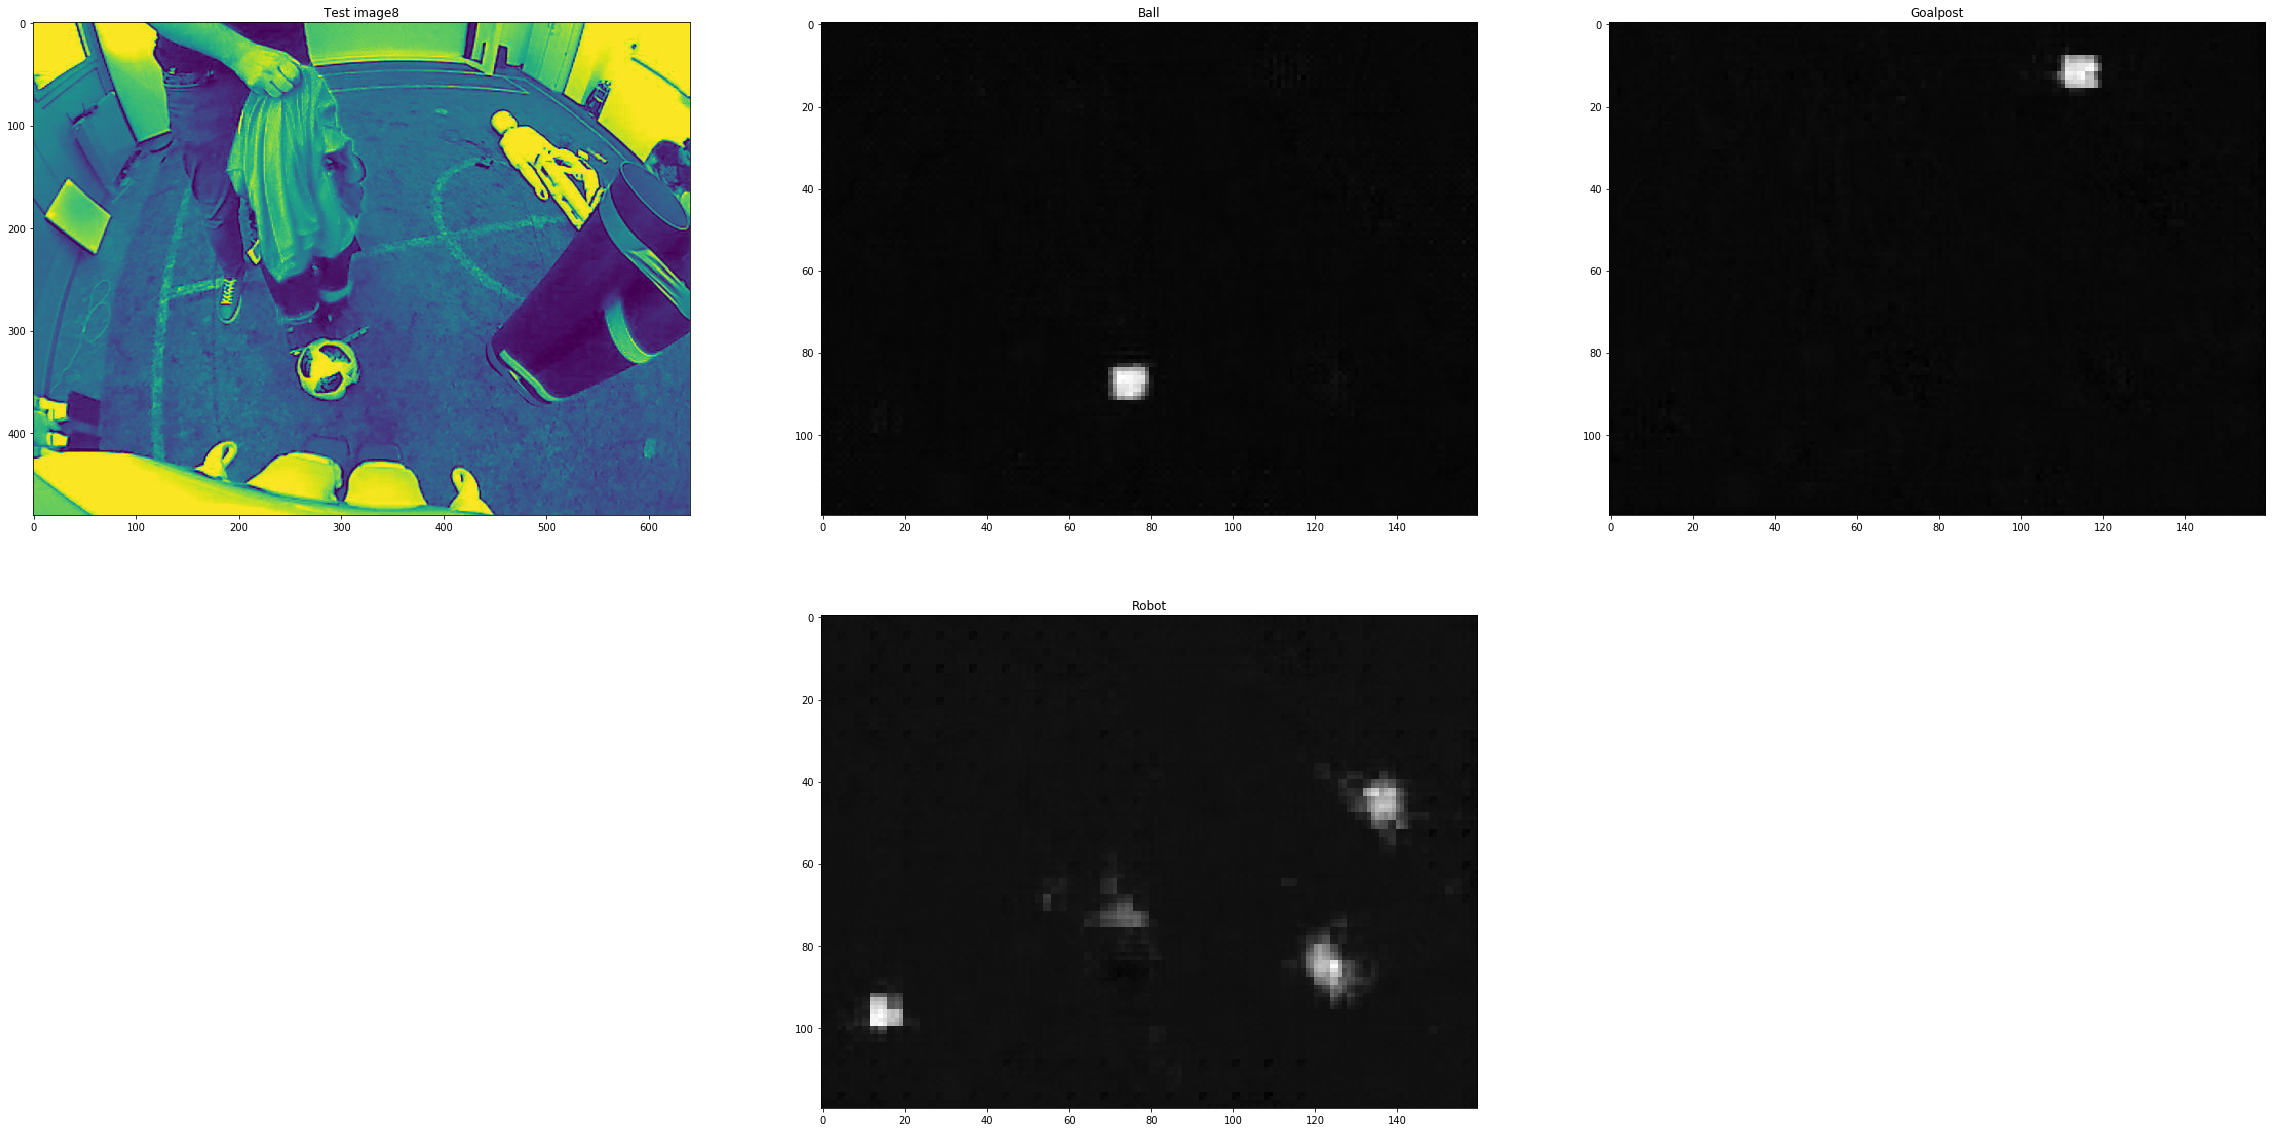

In [14]:
test_transforms = [Rescale((480,640)),
              ToTensor(), 
              Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])]

test_dataset = BlobTestDataset(path = '../Project/data/blob/forceTest',transform=test_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=1, 
                                           shuffle=True)

seg_test_dataset = SegDataset(path = '../Project/data/segmentation/forceTrain',transform=None)
seg_test_loader = torch.utils.data.DataLoader(dataset=seg_test_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

blob_test(model, test_loader, avDev)
blob_test_output(model, test_loader, avDev)

In [ ]:
for j,test_data in enumerate(seg_test_loader):
      
    images = test_data[0].to(avDev)
    label = test_data[1].to(avDev)
    
    images.requires_grad_(False)
    label.requires_grad_(False)
    
    batch = test_data['image'].shape[0]
    
    for i in range(5):
        k += 1
        plt.figure(figsize=(40,20))
        plt.subplot(2,3,1)
        plt.title('Test image' + str(k))
        plt.imshow(images[0][i].cpu())
        out = model(images)
        plt.subplot(2,3,2)
        plt.title('Ball')
        plt.imshow(out[i][0].cpu().detach().numpy(), cmap= 'gray')
        plt.subplot(2,3,3)
        plt.title('Goalpost')
        plt.imshow(out[i][1].cpu().detach().numpy(), cmap= 'gray')
        plt.subplot(2,3,5)
        plt.title('Robot')
        plt.imshow(out[i][2].cpu().detach().numpy(), cmap= 'gray')
        plt.show()